In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import shutil
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import zipfile
import xarray as xr

curr_dir = pathlib.Path(".")
data_dir = curr_dir / "RTS-GMLC-master" / "RTS_Data"

In [2]:
# Read in bus/line geodata for IEEE RTS GMLC (Reliability Test System)
df_bus = pd.read_csv(data_dir / "SourceData" / "bus.csv", index_col=[0])
df_geodata = df_bus[["lat", "lng"]]
df_line = pd.read_csv(data_dir / "SourceData" / "branch.csv")
df_line = df_line.set_index(["From Bus", "To Bus"])

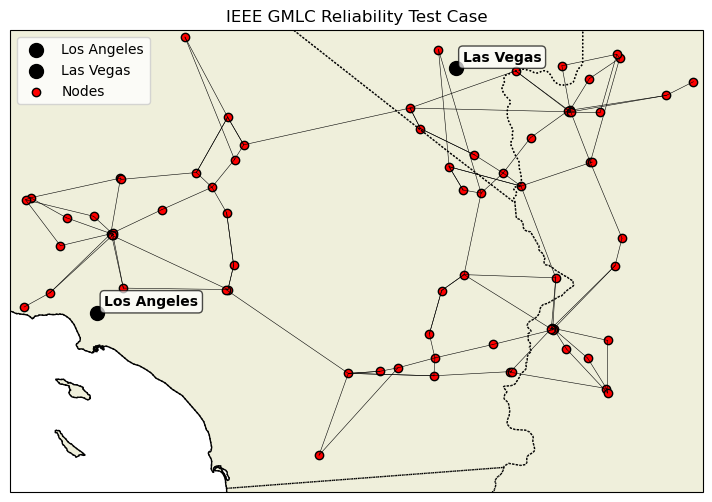

In [3]:
# Overlay system on map of US Southwest
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features (coastlines, states)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.STATES, linestyle=':')

# Plot cities
cities = {
    "Los Angeles": (34.0522, -118.2437),
    "Las Vegas": (36.1699, -115.1398)
}
for city, (lat, lon) in cities.items():
    ax.scatter(lon, lat, color='black', edgecolor='black', s=100, label=city)
    ax.annotate(city, xy=(lon, lat), xytext=(5, 5), textcoords="offset points",
                fontsize=10, fontweight="bold", color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="black", boxstyle="round,pad=0.3"))

# Plot lines
for from_bus, to_bus in df_line.index:
    ax.plot(df_geodata.loc[[from_bus, to_bus], "lng"], df_geodata.loc[[from_bus, to_bus], "lat"], color="black", linewidth=0.4)

# Plot nodes
ax.scatter(df_geodata["lng"], df_geodata["lat"], color='red', edgecolor="black", transform=ccrs.PlateCarree(), label='Nodes')
ax.set_extent([-119, -113, 32.5, 36.5], crs=ccrs.PlateCarree())

plt.legend()
plt.title("IEEE GMLC Reliability Test Case")
plt.show()

In [4]:
import cdsapi
import time

# Get study area
lat_min = df_geodata["lat"].min() - 0.25
lat_max = df_geodata["lat"].max() + 0.25
lon_min = df_geodata["lng"].min() - 0.25
lon_max = df_geodata["lng"].max() + 0.25
area = [lat_max, lon_min, lat_min, lon_max]

# Initialize the CDS API client
c = cdsapi.Client()

# Define the dataset and request parameters
dataset = "reanalysis-era5-single-levels"

# Define chunks
months = [str(m).zfill(2) for m in np.arange(12) + 1]
chunks = [months[0:4], months[4:8], months[8:12]]

# Define coverage years
years = np.arange(1982, 2025)
for y in years:
    for j,chunk in enumerate(chunks):
        print(f"Downloading data for {y} - chunk {j+1} {chunk}...")
        # Formulate request
        request = {
            "product_type": "reanalysis",
            "variable": ["2m_temperature", "clear_sky_direct_solar_radiation_at_surface", "surface_solar_radiation_downwards", "total_cloud_cover", "100m_u_component_of_wind", "100m_v_component_of_wind"],
            "year": [str(y)],
            "month": [str(m).zfill(2) for m in chunk],
            "day": [str(d+1).zfill(2) for d in np.arange(31)],
            "time": [f"{str(h).zfill(2)}:00" for h in range(24)],
            "area": area,     # [North, West, South, East] # IEEE RTS GMLC Test System coordinates
            "format": "netcdf"               # File format (NetCDF or GRIB)
        }
        # Retrieve data
        fname = f"weather-data/weather-data-{y}-chunk{j+1}.nc"
        if not os.path.exists(fname):
            c.retrieve(dataset, request).download(fname)
            print("Done.")
            time.sleep(10)
        else:
            print(f"File {fname} already exists, skipping.")

print("Data download complete!")

File weather-data/weather-data-1982-chunk1.nc already exists, skipping.
File weather-data/weather-data-1982-chunk2.nc already exists, skipping.
File weather-data/weather-data-1982-chunk3.nc already exists, skipping.
File weather-data/weather-data-1983-chunk1.nc already exists, skipping.
File weather-data/weather-data-1983-chunk2.nc already exists, skipping.
File weather-data/weather-data-1983-chunk3.nc already exists, skipping.
File weather-data/weather-data-1984-chunk1.nc already exists, skipping.
File weather-data/weather-data-1984-chunk2.nc already exists, skipping.


2025-10-30 23:37:46,670 INFO Request ID is fd446bdb-ab25-47ce-9e61-ac4df822b29e
2025-10-30 23:37:46,883 INFO status has been updated to accepted
2025-10-30 23:46:14,081 INFO status has been updated to successful


528f03a2b7b7c835da2b0c056c90a105.zip:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Done.


2025-10-30 23:46:31,183 INFO Request ID is 00e58cd6-cb6e-41c3-8a6a-1f744ba5a53f
2025-10-30 23:46:31,428 INFO status has been updated to accepted
2025-10-30 23:46:46,121 INFO status has been updated to running
2025-10-31 00:09:07,955 INFO status has been updated to successful


dbbfeb165bcd153247bc06a1405931d5.zip:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Done.


2025-10-31 00:09:24,390 INFO Request ID is 43a2b2be-ce4d-4a7f-8dba-9a028a3c8264
2025-10-31 00:09:24,624 INFO status has been updated to accepted
2025-10-31 00:09:39,292 INFO status has been updated to running
2025-10-31 00:34:01,266 INFO status has been updated to successful


b7b82abc58bf516ef393cbf4fc1c06e1.zip:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Done.


2025-10-31 00:34:16,635 INFO Request ID is 1aa29dca-9e85-496c-8570-ec1d5c8de090
2025-10-31 00:34:16,942 INFO status has been updated to accepted
2025-10-31 00:34:26,023 INFO status has been updated to running
2025-10-31 00:56:50,589 INFO status has been updated to successful


2de0aa49aa5378b7d6c2fb34e7420470.zip:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Done.


2025-10-31 00:57:08,140 INFO Request ID is a307007f-acd2-495e-9129-d2b844b9fac6
2025-10-31 00:57:08,365 INFO status has been updated to accepted
2025-10-31 00:57:23,078 INFO status has been updated to running
2025-10-31 01:19:45,893 INFO status has been updated to successful


8ea13e1ee098d29bace1e013dad0e114.zip:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Done.


2025-10-31 01:20:01,985 INFO Request ID is b919ad73-6700-444a-a284-8793bec8bd8b
2025-10-31 01:20:02,183 INFO status has been updated to accepted
2025-10-31 01:21:20,442 INFO status has been updated to running
2025-10-31 01:44:39,020 INFO status has been updated to successful


42210e579ed32e082ae93f1c33ac1567.zip:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Done.


2025-10-31 01:44:55,563 INFO Request ID is 0cb801e1-9b8f-40f5-9824-96da78bc0a6e
2025-10-31 01:44:55,759 INFO status has been updated to accepted
2025-10-31 01:49:19,181 INFO status has been updated to running
2025-10-31 02:17:41,414 INFO status has been updated to successful


216eb4ac8737a47ea2fb96b0dd70905f.zip:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Done.


2025-10-31 02:17:57,803 INFO Request ID is 5f4216ef-fea0-47d4-a49f-8523b5410a42
2025-10-31 02:17:58,025 INFO status has been updated to accepted
2025-10-31 02:18:32,732 INFO status has been updated to running
2025-10-31 02:42:40,254 INFO status has been updated to successful


9082df0898a54f9eeb4a8ad3dfd521cf.zip:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Done.


2025-10-31 02:42:58,594 INFO Request ID is 725a388c-6914-496f-b6ad-eb0c4cf30eb1
2025-10-31 02:42:58,837 INFO status has been updated to accepted
2025-10-31 02:44:18,277 INFO status has been updated to running
2025-10-31 03:07:38,276 INFO status has been updated to successful


b43ef9f14390fe58c53f43bb3700e1c9.zip:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Done.


2025-10-31 03:07:56,395 INFO Request ID is 64a6e2c7-4cd1-4143-b3b8-ba6674d0746b
2025-10-31 03:07:56,614 INFO status has been updated to accepted
2025-10-31 03:22:27,230 INFO status has been updated to running
2025-10-31 03:44:47,013 INFO status has been updated to successful


352d632ed527879c38a7611e59f9b902.zip:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Done.


2025-10-31 03:45:03,738 INFO Request ID is fc2abcaf-913c-4b3a-a8f3-170670dca95a
2025-10-31 03:45:03,956 INFO status has been updated to accepted
2025-10-31 03:57:37,248 INFO status has been updated to running
2025-10-31 04:19:55,192 INFO status has been updated to successful


2e609ea68fdf995e85beeee1bcdb2365.zip:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Done.


2025-10-31 04:20:10,416 INFO Request ID is 9ef5b912-3ddf-47db-a6af-2a54bde4a33d
2025-10-31 04:20:10,623 INFO status has been updated to accepted
2025-10-31 04:38:48,210 INFO status has been updated to running
2025-10-31 05:01:06,094 INFO status has been updated to successful


92b16b124dfb16aacb198338d5d084d2.zip:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Done.


2025-10-31 05:01:21,362 INFO Request ID is a81f3775-59c6-4819-a091-d0e5ee69f4ff
2025-10-31 05:01:21,588 INFO status has been updated to accepted
2025-10-31 05:19:56,488 INFO status has been updated to running
2025-10-31 05:42:15,079 INFO status has been updated to successful


fbf3defda9547267b009198dd0c4f845.zip:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Done.


2025-10-31 05:42:32,155 INFO Request ID is a44caaec-8e4a-4337-ad53-01053beef998
2025-10-31 05:42:32,378 INFO status has been updated to accepted
2025-10-31 06:19:19,534 INFO status has been updated to running
2025-10-31 06:39:39,628 INFO status has been updated to successful


763c29609db65ccab456bf22bc29d032.zip:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Done.


2025-10-31 06:39:56,195 INFO Request ID is 7323255f-91af-4d1f-815d-a69289c94b18
2025-10-31 06:39:56,502 INFO status has been updated to accepted
2025-10-31 07:55:20,745 INFO status has been updated to running
2025-10-31 08:17:36,879 INFO status has been updated to successful


c24a946f5cdb442b5958c3839f17d0f0.zip:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Done.


2025-10-31 08:17:53,548 INFO Request ID is 568fea98-4b79-4c2d-ac46-b2b8e81c4b2f
2025-10-31 08:17:54,572 INFO status has been updated to accepted
2025-10-31 08:40:32,741 INFO status has been updated to running
2025-10-31 09:04:47,951 INFO status has been updated to successful


28b957edd361a40a0fd8fe8680c322e5.zip:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

Done.


2025-10-31 09:05:03,609 INFO Request ID is f99a9019-2d47-4e6a-b33c-cb45107912ac
2025-10-31 09:05:03,813 INFO status has been updated to accepted


KeyboardInterrupt: 

In [ ]:
# Extract data from zip files
extract_to = curr_dir / "weather-data" / "extracted-data"
for zip_path in zip_files:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extracted_files = zip_ref.namelist()
        zip_ref.extractall(extract_to)
        for file_name in extracted_files:
            file_path = extract_to / file_name
            data_type = file_path.stem.split("-")[-1]
            file_path.rename(curr_dir / "weather-data" / f"{data_type}-data" / (zip_path.stem + "-" + data_type + ".nc"))
print("Extraction complete.")

In [ ]:
# Open instant data files and sort chronologically
instant_files = sorted(list((curr_dir / "weather-data-RTS-GMLC" / "instant-data").glob("*")), key=lambda f: f.stem.split("_")[-1])

# Combine into a single file
ds = xr.open_mfdataset(
    instant_files, 
    combine="by_coords",
    engine="netcdf4",
    chunks="auto",
)

# Save the merged dataset
# ds.to_netcdf(curr_dir / "weather-data-RTS-GMLC" / "weather_data-instant.nc", format="NETCDF4", engine="netcdf4")

In [ ]:
# Convert to pandas dataframe for analysis
df = ds.to_dataframe()
df.index